# Visual Analytics - Text Mining Lord of the Rings Movie Scripts

In [510]:
# Setup
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import altair as alt
import csv

import re
from PIL import Image
# import nltk
# nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud

In [454]:
# load data - https://www.kaggle.com/paultimothymooney/lord-of-the-rings-data
scripts = pd.read_csv('data/lotr_scripts.csv', index_col=0)
chars = pd.read_csv('data/lotr_characters.csv')

In [455]:
scripts.head(3)

,char,dialog,movie
0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeag...",The Return of the King
1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!",The Return of the King
2,DEAGOL,Arrghh!,The Return of the King


In [456]:
chars.head(3)

,birth,death,gender,hair,height,name,race,realm,spouse
0,NaN,NaN,Female,NaN,NaN,Adanel,Men,NaN,Belemir
1,TA 2978,"February 26 ,3019",Male,Dark (book) Light brown (movie),NaN,Boromir,Men,NaN,NaN
2,NaN,"March ,3019",Male,NaN,NaN,Lagduf,Orcs,NaN,NaN


In [457]:
# load books.txt https://github.com/tianyigu/Lord_of_the_ring_project/tree/master/LOTR_code/lotr_script_scripy/lotr
# read textfile
lotr1 = pd.read_csv('data/book1.txt', sep='\n', header=None, encoding='utf-8', quoting=csv.QUOTE_NONE)
lotr2 = pd.read_csv('data/book2.txt', sep='\n', header=None, encoding='utf-8', quoting=csv.QUOTE_NONE)
lotr3 = pd.read_csv('data/book3.txt', sep='\n', header=None, encoding='utf-8', quoting=csv.QUOTE_NONE)

# change column name to 'text'
lotr1.columns = ['text']
lotr2.columns = ['text']
lotr3.columns = ['text']

In [458]:
# lotr1: remove title, contents, foreword and prologue
idx = lotr1[lotr1['text'].str.contains('\* BOOK I \*')].index 
lotr1 = lotr1.iloc[idx[0]:, :]

# lotr2: remove title
idx = lotr2[lotr2['text'].str.contains('\* BOOK III \*')].index 
lotr2 = lotr2.iloc[idx[0]:, :]

# lotr3: remove title
idx = lotr3[lotr3['text'].str.contains('\* BOOK V \*')].index 
lotr3 = lotr3.iloc[idx[0]:-18, :]

In [459]:
# Add book name to lotr
lotr1['book'] = 'The Fellowship of the Ring'
lotr2['book'] = 'The Two Towers'
lotr3['book'] = 'The Return of the King'

In [460]:
# combine books into one dataframe
lotr = pd.concat([lotr1, lotr2, lotr3]).reset_index(drop=True)

In [461]:
# Add book and chapter information
lotr['sub_book'] = lotr['text'].str.extract(r'(\* BOOK .* \*)', expand=False)
lotr['chapter'] = lotr['text'].str.extract(r'(^Chapter .*)', expand=False)

# fill empty rows with last available value
lotr['sub_book'] = lotr['sub_book'].fillna(method='ffill')
lotr['chapter'] = lotr['chapter'].fillna(method='ffill')

# remove book and chapter headings
lotr = lotr[lotr.apply(lambda x: x.sub_book not in x.text, axis=1)].copy() #  remove book headers
lotr = lotr[lotr.apply(lambda x: x.chapter not in x.text, axis=1)].copy() #   remove chapter headers

In [462]:
# make numberic book
book_to_num = {'The Fellowship of the Ring': 1,
               'The Two Towers': 2,
               'The Return of the King': 3}

lotr['book_num'] = lotr['book'].map(book_to_num)

# make numberic sub book
sub_book_to_num = {'* BOOK I *': 1,
                   '* BOOK II *': 2,
                   '* BOOK III *': 3,
                   '* BOOK IV *': 4,
                   '* BOOK V *': 5,
                   '* BOOK VI *': 6,
                   '* BOOK VII *': 7}

lotr['sub_book_num'] = lotr['sub_book'].map(sub_book_to_num)

# make numberic chapters
lotr['chapter_num'] = lotr['chapter'].str.extract('(\d+)').astype(int)
lotr

,text,book,sub_book,chapter,book_num,sub_book_num,chapter_num
2,When Mr. Bilbo Baggins of Bag End announced th...,The Fellowship of the Ring,* BOOK I *,Chapter 1 . A Long-expected Party,1,1,1
3,celebrating his eleventy -first birthday with ...,The Fellowship of the Ring,* BOOK I *,Chapter 1 . A Long-expected Party,1,1,1
4,"magnificence, there was much talk and exciteme...",The Fellowship of the Ring,* BOOK I *,Chapter 1 . A Long-expected Party,1,1,1
5,"Bilbo was very rich and very peculiar, and had...",The Fellowship of the Ring,* BOOK I *,Chapter 1 . A Long-expected Party,1,1,1
6,"Shire for sixty years, ever since his remarkab...",The Fellowship of the Ring,* BOOK I *,Chapter 1 . A Long-expected Party,1,1,1
...,...,...,...,...,...,...,...
38506,"went. But Sam turned to Bywater, and so came b...",The Return of the King,* BOOK VI *,Chapter 9 . The Grey Havens,3,6,9
38507,"ending once more. And he went on, and there wa...",The Return of the King,* BOOK VI *,Chapter 9 . The Grey Havens,3,6,9
38508,"within; and the evening meal was ready, and he...",The Return of the King,* BOOK VI *,Chapter 9 . The Grey Havens,3,6,9
38509,"him in, and set him in his chair, and put litt...",The Return of the King,* BOOK VI *,Chapter 9 . The Grey Havens,3,6,9


In [463]:
### PLAN FOR ANALYSIS

# **** General overview of books ****
# Wordcloud of each movie ( + text cleaning as needed )
# Correlogramm of books

# **** Time series analysis ****
# Heatmap of when each character appears in book timeline (character mentions)
# Other keyword frequencies
# Sentiment time series + smoothing
# Sentiment analysis per chapter?

# **** Character / World ****
# Network analysis of characters (group X sentences together, check cooccurences )
# Degree of centrality ( connectedness of characters )

# Nr of new words introduced

### 1) Book Structure

In [464]:
lotr['word_count'] = lotr['text'].apply(lambda x: len(x.split()))
word_count = lotr.groupby(['book_num', 'sub_book_num', 'chapter_num', 'book', 'sub_book', 'chapter']).agg({'word_count': 'sum'}).reset_index()
word_count

,book_num,sub_book_num,chapter_num,book,sub_book,chapter,word_count
0,1,1,1,The Fellowship of the Ring,* BOOK I *,Chapter 1 . A Long-expected Party,9869
1,1,1,2,The Fellowship of the Ring,* BOOK I *,Chapter 2 . The Shadow of the Past,11182
2,1,1,3,The Fellowship of the Ring,* BOOK I *,Chapter 3 . Three is Company,9647
3,1,1,4,The Fellowship of the Ring,* BOOK I *,Chapter 4 . A Short Cut to Mushrooms,5842
4,1,1,5,The Fellowship of the Ring,* BOOK I *,Chapter 5 . A Conspiracy Unmasked,5125
...,...,...,...,...,...,...,...
57,3,6,5,The Return of the King,* BOOK VI *,Chapter 5 . The Steward and the King,7606
58,3,6,6,The Return of the King,* BOOK VI *,Chapter 6. Many Partings,7367
59,3,6,7,The Return of the King,* BOOK VI *,Chapter 7 . Homeward Bound,3984
60,3,6,8,The Return of the King,* BOOK VI *,Chapter 8 . The Scouring of the Shire,10932


In [465]:
# Plot stacked barchart of word_count per book
scale = alt.Scale(
    domain=lotr.sub_book.unique(),
    range=['grey', 'darkgrey'],
    padding=.91
)

bars = alt.Chart(word_count).mark_bar().encode(
    x=alt.X('sum(word_count):Q', stack='zero'),
    y=alt.Y('book:N', sort='-x'),
    color=alt.Color('sub_book:N', scale=alt.Scale(scheme='greys')),
    order=alt.Order('sum(word_count):Q', sort='descending')
)
bars
# text = alt.Chart(source).mark_text(dx=-15, dy=3, color='white').encode(
#     x=alt.X('sum(yield):Q', stack='zero'),
#     y=alt.Y('variety:N'),
#     detail='site:N',
#     text=alt.Text('sum(yield):Q', format='.1f')
# )

# bars + text

alt.Chart(...)

### 2) Wordclouds

In [466]:
def clean_texts(text_col):
    print("Cleaning {}...".format(text_col.name))

    # define stop words
    stop_words = set(stopwords.words('english'))
    #stop_words.update(('stop1', 'stop2')) # add custom stop words

    text_col = text_col.apply(lambda x: re.sub('[^A-Za-z ]+', ' ', x))  # remove special characters and numbers
    #text_col = text_col.apply(lambda x: x.lower())  # convert to lower

    words = text_col.apply(lambda x: [w for w in word_tokenize(x)])  # splits text_col into words
    words = words.apply(lambda x: [w for w in x if w not in stop_words])  # remove stopwords
    
    words = words.apply(lambda x: [WordNetLemmatizer().lemmatize(t) for t in x])  # lemmatize words
    text_col = words.apply(lambda x: ' '.join(x))  # join words back together

    # text_col = text_col.apply(lambda x: re.sub(r"\b[a-zA-Z]\b", "", x))  # remove all single letters
    return text_col

In [467]:
# clean text
lotr['text_clean'] = clean_texts(lotr['text'])

Cleaning text...


In [469]:
# tag all nouns in text
def tag_and_filter_nouns(text_col):
    print("Tagging {}...".format(text_col.name))
    text_col = text_col.apply(lambda x: pos_tag(word_tokenize(x)))
    text_col = text_col.apply(lambda x: [word for word, tag in x if tag in ['NN', 'NNP', 'NNS', 'NNPS']])
    return text_col	

lotr['nouns'] = tag_and_filter_nouns(lotr['text'])
lotr['nouns'] = lotr['nouns'].apply(lambda x: ' '.join(x))

Tagging text...


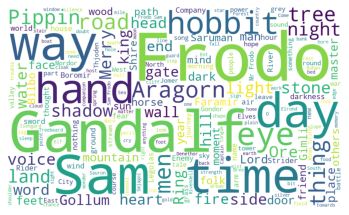

In [516]:
# Plot Wordcloud
wordcloud_text = ' '.join(lotr['nouns'])
wordcloud = WordCloud(background_color='white', width=1000, height=600, 
                      max_words=200, max_font_size=200).generate(wordcloud_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

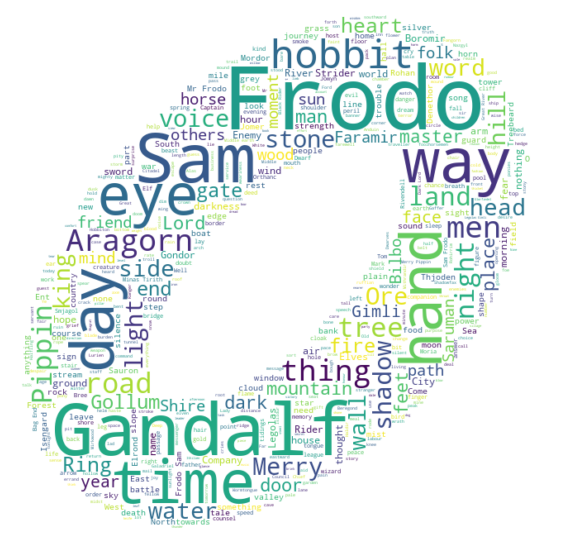

In [528]:
# Plot Wordcloud
fig=plt.figure(figsize=(10,10))
mask = np.array(Image.open('data/ring2.png'))
wordcloud_text = ' '.join(lotr['nouns'])
wordcloud = WordCloud(background_color='white', mask=mask, width=mask.shape[1], height=mask.shape[0], 
                      max_words=500, max_font_size=500)
wordcloud.generate(wordcloud_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

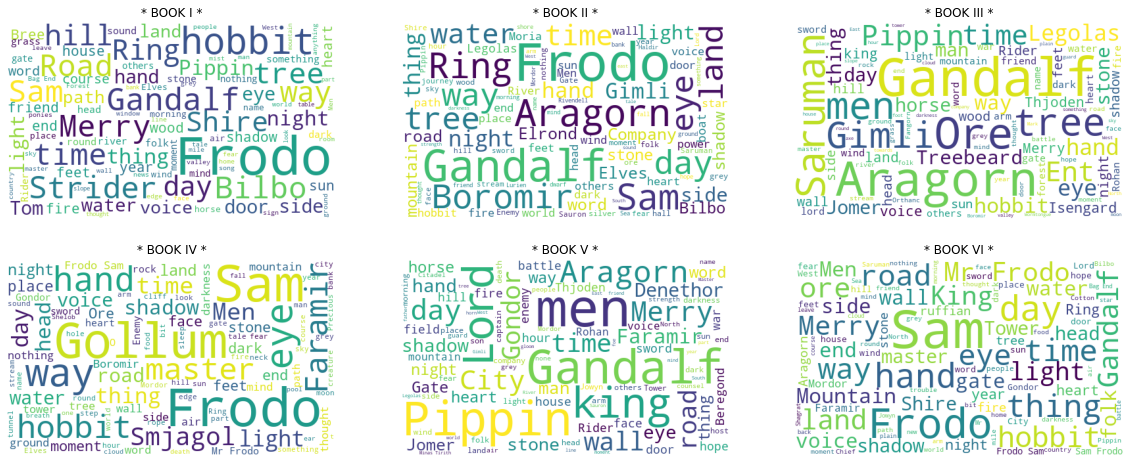

In [470]:
# Wordcloud per book
fig, axs = plt.subplots(2, 3, figsize=(20, 8))
axs = axs.ravel()

for i, book in enumerate(lotr['sub_book'].unique()):
    # create wordcloud
    book_txt = ' '.join(lotr.loc[lotr['sub_book'] == book, 'nouns'])
    wordcloud = WordCloud(background_color='white', width=500, height=300, max_words=100, max_font_size=80).generate(book_txt)
    # plot wordcloud
    axs[i].imshow(wordcloud)
    axs[i].set_title(book)
    axs[i].axis('off')
plt.show()

In [502]:
chapters = lotr.groupby(['sub_book', 'chapter_num', 'chapter'])['text_clean'].apply(' '.join).reset_index()
chapters['sentences'] = 

,sub_book,chapter_num,chapter,text_clean
0,* BOOK I *,1,Chapter 1 . A Long-expected Party,When Mr Bilbo Baggins Bag End announced would ...
1,* BOOK I *,2,Chapter 2 . The Shadow of the Past,The talk die nine even ninety nine day The sec...
2,* BOOK I *,3,Chapter 3 . Three is Company,You ought go quietly ought go soon said Gandal...
3,* BOOK I *,4,Chapter 4 . A Short Cut to Mushrooms,In morning Frodo woke refreshed He lying bower...
4,* BOOK I *,5,Chapter 5 . A Conspiracy Unmasked,Now better get home said Merry There something...
...,...,...,...,...
57,* BOOK VI *,5,Chapter 5 . The Steward and the King,Over city Gondor doubt great dread hung Fair w...
58,* BOOK VI *,6,Chapter 6. Many Partings,When day rejoicing last Companions thought ret...
59,* BOOK VI *,7,Chapter 7 . Homeward Bound,At last hobbit face turned towards home They e...
60,* BOOK VI *,8,Chapter 8 . The Scouring of the Shire,It nightfall wet tired traveller came last Bra...


In [503]:
# Calculate sentiment score per chapter
chapters['sentiment_score'] = chapters['text_clean'].apply(lambda x: TextBlob(x).sentiment.polarity)
chapters['sentiment_score'] = chapters['sentiment_score'].apply(lambda x: round(x, 2))

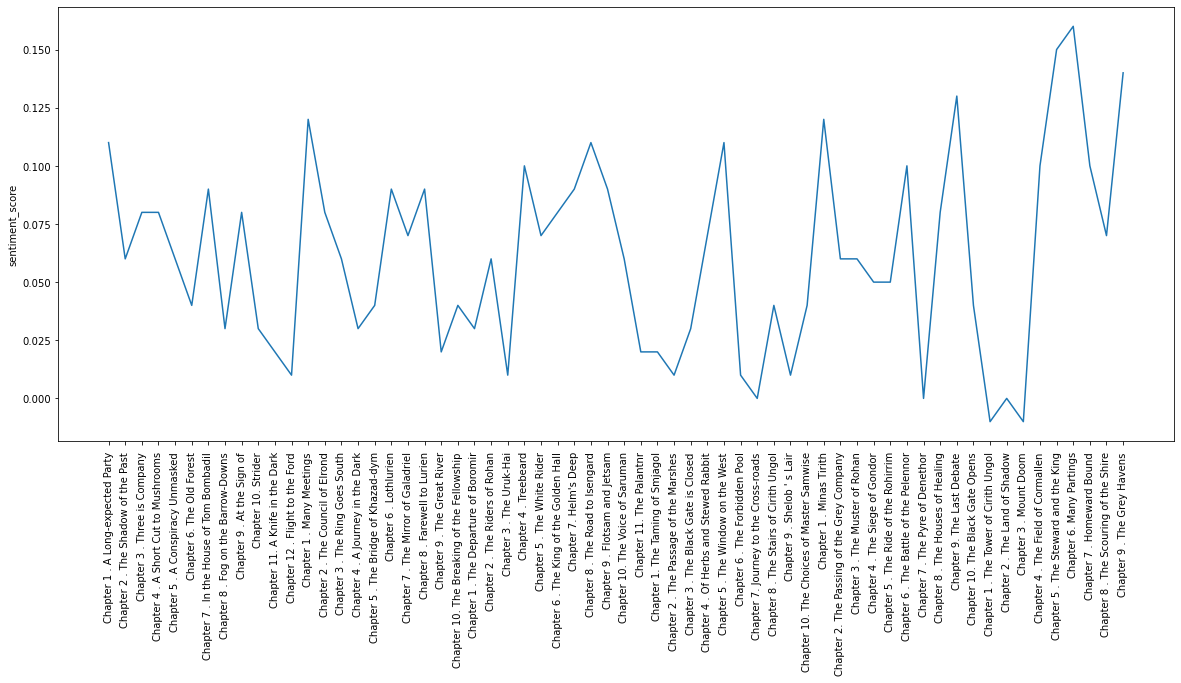

In [504]:
# Plot sentiment score per chapter
fig = plt.figure(figsize=(20, 8))
sns.lineplot(x=chapters.index, y='sentiment_score', data=chapters)
# set xticks to chapter 
plt.xticks(chapters.index, chapters['chapter'], rotation=90)
plt.show()